# Traffic sign detection and classification (with deep learning)

In [1]:
import cv2 as cv
import os
import random
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import xml.etree.ElementTree as ET
from utils import ModelTrainer, displayImage, importImage, plotTrainingHistory

/home/jm/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Data preparation

In [2]:
# Get train and validation datasets
images_directory = "../dataset/images"
annotations_directory = "../dataset/annotations"

with open("train.txt") as train:
    train_images_filenames = sorted(train.read().splitlines())

with open("test.txt") as test:
    val_images_filenames = sorted(test.read().splitlines())

# Filter out images that can not be loaded properly
train_images_filenames = [i for i in train_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]
val_images_filenames = [i for i in val_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]

random.seed(42)
random.shuffle(train_images_filenames)
random.shuffle(val_images_filenames)

print(len(train_images_filenames), len(val_images_filenames))

613 264


## Dataset class

In [3]:
classes = {
    "trafficlight": 0,
    "stop": 1,
    "speedlimit": 2,
    "crosswalk": 3,
}

class TrafficSignDataset(Dataset):
    def __init__(self, annotations_directory, images_filenames, images_directory, transform=None):
        self.annotations_directory = annotations_directory
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv.imread(os.path.join(
            self.images_directory, image_filename + ".png"))
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # transform image into 0-1 range
        # note that the ToTensorV2 method from the albumentations library does not automatically convert the image range into 0-1
        image = image / 255.

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image.float(), self._get_max_area_class_from_annotion(image_filename)

    def _get_max_area_class_from_annotion(self, filename):
        with open(os.path.join(self.annotations_directory, filename + ".xml")) as xml:
            tree = ET.parse(xml)
            root = tree.getroot()

            max_area_class = "trafficlight"
            max_area = -1

            objects = root.findall("object")
            for object in objects:
                xmin = int(object.find("bndbox/xmin").text)
                ymin = int(object.find("bndbox/ymin").text)
                xmax = int(object.find("bndbox/xmax").text)
                ymax = int(object.find("bndbox/ymax").text)

                area = (xmax - xmin) * (ymax - ymin)

                if area > max_area:
                    max_area = area
                    max_area_class = object.find("name").text

        return classes[max_area_class]

## Load data

road285
2


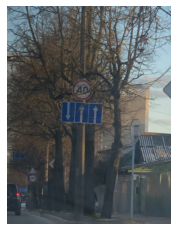

In [4]:
batch_size = 126
num_workers = 2 # How many processes are used to load the data

train_transform = A.Compose(
    [
        A.Resize(256, 256),
        ToTensorV2(),
    ]
)
train_dataset = TrafficSignDataset(annotations_directory, train_images_filenames, images_directory, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)


val_transform = A.Compose(
    [A.Resize(256, 256), ToTensorV2()]
)
val_dataset = TrafficSignDataset(annotations_directory, val_images_filenames, images_directory, transform=val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

index = 10
print(train_images_filenames[index])
# displayImage(train_dataset[index][0])
print(train_dataset[index][1])
displayImage(importImage(train_images_filenames[index]))

## Train the model

In [5]:
num_classes = len(classes)

# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### ResNet-50 pretrained

In [6]:
resnet_model = models.resnet50(pretrained=True)
# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
resnet_model.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)
resnet_model.to(device)

resnet = {
    "model": resnet_model,
    "name": 'resnet50',
    #"num_epochs": 50,
    "num_epochs": 1,
    "loss": nn.CrossEntropyLoss(),  # already includes the Softmax activation
    "optimizer": torch.optim.SGD(resnet_model.parameters(), lr=1e-3)
}

print(resnet)

{'model': ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

Only train last layer

Loaded resnet50 obtained in epoch 0


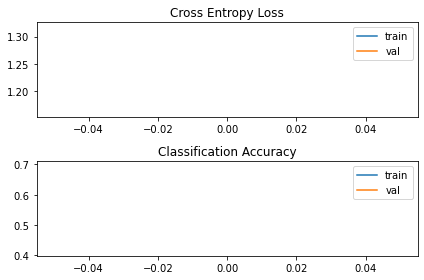

In [7]:
resnet_trainer = ModelTrainer(resnet, device)
# Unfreeze all layers expect last
resnet_trainer.freeze_layers()
resnet_trainer.unfreeze_fc()
resnet_train_history, resnet_val_history = resnet_trainer.train(train_dataloader, val_dataloader, force_load_model=True)

plotTrainingHistory(resnet_train_history, resnet_val_history)

In [8]:
preds, actual_y = resnet_trainer.predict_data(val_dataloader)

Predicting data


100%|██████████| 3/3 [00:44<00:00, 14.68s/it]


In [9]:
print(preds)
print("-")
print(actual_y)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
-
tensor([2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 3,
        2, 1, 2, 2, 2, 1, 2, 1, 2, 2,

In [11]:
from torchmetrics import MetricCollection, Accuracy, Precision, Recall
metric_collection = MetricCollection([
    Accuracy(),
    Precision(num_classes=num_classes, average='macro'),
    Recall(num_classes=num_classes, average='macro')
])
metric_collection(preds, actual_y)

{'Accuracy': tensor(0.6970), 'Precision': tensor(0.1797), 'Recall': tensor(0.2396)}


### VGG-16

In [ ]:
# Load model from torchvision (with pretrained=True)
vgg_model = models.vgg16(pretrained=True)
# Change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
vgg_model.classifier[6] = nn.Linear(4096, num_classes)
vgg_model.to(device)

vgg = {
    "model": vgg_model,
    "name": 'vgg16',
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),  # already includes the Softmax activation
    "optimizer": torch.optim.SGD(vgg_model.parameters(), lr=1e-3)
}
print(vgg)

Only train last layers

Train from scratch

In [ ]:
vg_trainer = ModelTrainer(vgg, device)
vgg_train_history, vgg_val_history = vg_trainer.train(train_dataloader, val_dataloader)

plotTrainingHistory(vgg_train_history, vgg_val_history)